Dataset: [MovieLens](https://grouplens.org/datasets/movielens/)

In [213]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from keras.models import Model
from keras.layers import Dense, Embedding, Input, Dot, Add, Flatten
from keras.optimizers import SGD, Adam
from keras.utils import to_categorical
from keras.regularizers import l2
import keras.backend as K
from sklearn.model_selection import train_test_split
%matplotlib inline

# Examinando el dataset

In [214]:
ratings = pd.read_csv('data/ml-latest-small/ratings.csv')
print(ratings.shape)
ratings.head(5)

(100004, 4)


,userId,movieId,rating,timestamp
0,1,31,2.5,1260759144
1,1,1029,3.0,1260759179
2,1,1061,3.0,1260759182
3,1,1129,2.0,1260759185
4,1,1172,4.0,1260759205


In [215]:
movie_names = pd.read_csv('data/ml-latest-small/movies.csv')
movie_names.head()

,movieId,title,genres
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,2,Jumanji (1995),Adventure|Children|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance
4,5,Father of the Bride Part II (1995),Comedy


In [216]:
# Justamos los 2 datasets y filtramos las columnas que nos interesan
ratings = ratings.join(movie_names, on='movieId', rsuffix='_')[['userId', 'movieId', 'rating', 'title', 'genres']]
ratings.head()

,userId,movieId,rating,title,genres
0,1,31,2.5,Twelve Monkeys (a.k.a. 12 Monkeys) (1995),Mystery|Sci-Fi|Thriller
1,1,1029,3.0,Highlander (1986),Action|Adventure|Fantasy
2,1,1061,3.0,Hype! (1996),Documentary
3,1,1129,2.0,Mars Attacks! (1996),Action|Comedy|Sci-Fi
4,1,1172,4.0,Gridlock'd (1997),Crime


In [217]:
# Obtenemos la lista de usuarios y peliculas unicas
users = ratings.userId.unique()
movies = ratings.movieId.unique()
users[:5], movies[:5]

(array([1, 2, 3, 4, 5]), array([  31, 1029, 1061, 1129, 1172]))

In [218]:
# Obtenemos un diccionario de IDs a numeros ordenados
userid2idx = {o:i for i,o in enumerate(users)}
movieid2idx = {o:i for i,o in enumerate(movies)}

# Reemplazamos los IDs por los codigos del diccionario
ratings.movieId = ratings.movieId.apply(lambda x: movieid2idx[x])
ratings.userId = ratings.userId.apply(lambda x: userid2idx[x])

ratings.head()

,userId,movieId,rating,title,genres
0,0,0,2.5,Twelve Monkeys (a.k.a. 12 Monkeys) (1995),Mystery|Sci-Fi|Thriller
1,0,1,3.0,Highlander (1986),Action|Adventure|Fantasy
2,0,2,3.0,Hype! (1996),Documentary
3,0,3,2.0,Mars Attacks! (1996),Action|Comedy|Sci-Fi
4,0,4,4.0,Gridlock'd (1997),Crime


In [219]:
# Cantidad de usuarios y peliculas
n_users = ratings.userId.nunique()
n_movies = ratings.movieId.nunique()
n_users, n_movies

(671, 9066)

# Crear el modelo

In [238]:
# Cuantos factores va a usar el Embedding para describir nuestras variables
n_factors = 25

# Embeddings para los usuarios
user_in = Input(shape=(1,), dtype='int64', name='user_in')
u = Embedding(n_users, n_factors, input_length=1, embeddings_regularizer=l2(1e-4))(user_in)

# Embeddings para las peliculas
movie_in = Input(shape=(1,), dtype='int64', name='movie_in')
m = Embedding(n_movies, n_factors, input_length=1, embeddings_regularizer=l2(1e-4))(movie_in)

In [239]:
x = Dot(axes=2)([u, m])
x = Flatten()(x)
model = Model(inputs=[user_in, movie_in], outputs=x)
model.compile(Adam(0.001), loss='mse')
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
user_in (InputLayer)            (None, 1)            0                                            
__________________________________________________________________________________________________
movie_in (InputLayer)           (None, 1)            0                                            
__________________________________________________________________________________________________
embedding_17 (Embedding)        (None, 1, 25)        16775       user_in[0][0]                    
__________________________________________________________________________________________________
embedding_18 (Embedding)        (None, 1, 25)        226650      movie_in[0][0]                   
__________________________________________________________________________________________________
dot_10 (Do

# Entrenar

In [242]:
df_train, df_test = train_test_split(ratings, test_size=0.2, random_state=42)
df_train.shape, df_test.shape

((80003, 10), (20001, 10))

In [243]:
log = model.fit([df_train.userId, df_train.movieId], df_train.rating, batch_size=512, epochs=10,
                validation_data=[[df_test.userId, df_test.movieId], df_test.rating])

Train on 80003 samples, validate on 20001 samples
Epoch 1/10
80003/80003 [==============================] - 1s 17us/step - loss: 13.6592 - val_loss: 13.6672
Epoch 2/10
80003/80003 [==============================] - 1s 12us/step - loss: 12.6514 - val_loss: 10.8631
Epoch 3/10
80003/80003 [==============================] - 1s 13us/step - loss: 8.0044 - val_loss: 5.7986
Epoch 4/10
80003/80003 [==============================] - 1s 12us/step - loss: 4.3542 - val_loss: 3.8699
Epoch 5/10
80003/80003 [==============================] - 1s 12us/step - loss: 3.1777 - val_loss: 3.2485
Epoch 6/10
80003/80003 [==============================] - 1s 12us/step - loss: 2.7169 - val_loss: 2.9581
Epoch 7/10
80003/80003 [==============================] - 1s 12us/step - loss: 2.4797 - val_loss: 2.8024
Epoch 8/10
80003/80003 [==============================] - 1s 13us/step - loss: 2.3429 - val_loss: 2.7120
Epoch 9/10
80003/80003 [==============================] - 1s 12us/step - loss: 2.2574 - val_loss: 2.6567
E

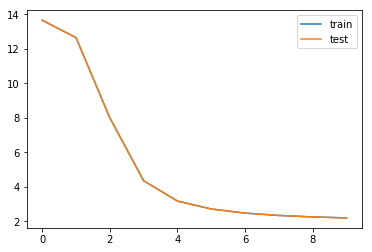

In [244]:
plt.plot(log.history['loss'], label='train')
plt.plot(log.history['loss'], label='test')
plt.legend()

In [245]:
sample = df_test.sample()
sample

,userId,movieId,rating,title,genres,movie_bias,user_bias,movie_pca0,movie_pca1,movie_pca2
24355,175,1240,3.0,Explorers (1985),Adventure|Children|Sci-Fi,0.87121,1.940736,-0.232721,0.339105,0.372271


In [246]:
model.predict([sample.userId, sample.movieId])

array([[2.8530319]], dtype=float32)

# Agregar un bias a la red

In [247]:
user_in = Input(shape=(1,), dtype='int64', name='user_in')
u = Embedding(n_users, n_factors, input_length=1, embeddings_regularizer=l2(1e-4))(user_in)

movie_in = Input(shape=(1,), dtype='int64', name='movie_in')
m = Embedding(n_movies, n_factors, input_length=1, embeddings_regularizer=l2(1e-4))(movie_in)

# Bias para los usuarios
u_bias = Embedding(n_users, 1, input_length=1)(user_in)
u_bias = Flatten()(u_bias)

# Bias para las peliculas
m_bias = Embedding(n_movies, 1, input_length=1)(movie_in)
m_bias = Flatten()(m_bias)

x = Dot(axes=2)([u, m])
x = Flatten()(x)

# Sumamos los bias al producto
x = Add()([x, u_bias])
x = Add()([x, m_bias])

model = Model(inputs=[user_in, movie_in], outputs=x)
model.compile(Adam(0.01), loss='mse')
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
user_in (InputLayer)            (None, 1)            0                                            
__________________________________________________________________________________________________
movie_in (InputLayer)           (None, 1)            0                                            
__________________________________________________________________________________________________
embedding_19 (Embedding)        (None, 1, 25)        16775       user_in[0][0]                    
__________________________________________________________________________________________________
embedding_20 (Embedding)        (None, 1, 25)        226650      movie_in[0][0]                   
__________________________________________________________________________________________________
dot_11 (Do

In [248]:
log = model.fit([df_train.userId, df_train.movieId], df_train.rating, batch_size=512, epochs=10,
                validation_data=[[df_test.userId, df_test.movieId], df_test.rating])

Train on 80003 samples, validate on 20001 samples
Epoch 1/10
80003/80003 [==============================] - 2s 20us/step - loss: 6.2758 - val_loss: 2.2152
Epoch 2/10
80003/80003 [==============================] - 1s 13us/step - loss: 1.9278 - val_loss: 1.9651
Epoch 3/10
80003/80003 [==============================] - 1s 12us/step - loss: 1.6918 - val_loss: 1.8407
Epoch 4/10
80003/80003 [==============================] - 1s 13us/step - loss: 1.5306 - val_loss: 1.7271
Epoch 5/10
80003/80003 [==============================] - 1s 13us/step - loss: 1.3799 - val_loss: 1.6072
Epoch 6/10
80003/80003 [==============================] - 1s 13us/step - loss: 1.2398 - val_loss: 1.4920
Epoch 7/10
80003/80003 [==============================] - 1s 12us/step - loss: 1.1142 - val_loss: 1.3896
Epoch 8/10
80003/80003 [==============================] - 1s 13us/step - loss: 0.9988 - val_loss: 1.2919
Epoch 9/10
80003/80003 [==============================] - 1s 14us/step - loss: 0.8996 - val_loss: 1.2135
Epoch

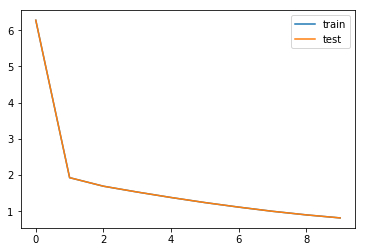

In [249]:
plt.plot(log.history['loss'], label='train')
plt.plot(log.history['loss'], label='test')
plt.legend()

In [250]:
sample = df_test.sample()
display(sample)
model.predict([sample.userId, sample.movieId])

,userId,movieId,rating,title,genres,movie_bias,user_bias,movie_pca0,movie_pca1,movie_pca2
68797,474,1808,2.0,NaN,NaN,-0.412854,1.900687,-0.276539,-0.149019,0.177309


array([[1.0638353]], dtype=float32)

# Exploramos los pesos entrenados

In [251]:
model.weights

[<tf.Variable 'embedding_19/embeddings:0' shape=(671, 25) dtype=float32_ref>,
 <tf.Variable 'embedding_20/embeddings:0' shape=(9066, 25) dtype=float32_ref>,
 <tf.Variable 'embedding_21/embeddings:0' shape=(671, 1) dtype=float32_ref>,
 <tf.Variable 'embedding_22/embeddings:0' shape=(9066, 1) dtype=float32_ref>]

In [252]:
K.eval(model.weights[0])

array([[ 5.48754483e-02,  1.21080026e-01, -2.54268907e-02, ...,
        -1.26121461e-01,  9.26381797e-02,  2.93352865e-02],
       [-2.26957947e-01, -3.65932882e-02, -2.06865624e-01, ...,
        -1.68970451e-01,  3.39510180e-02,  3.01318944e-01],
       [ 4.66972888e-02,  4.35889848e-02, -4.76128869e-02, ...,
        -1.64901882e-01,  3.61165591e-02,  6.20884384e-06],
       ...,
       [-1.86037272e-01, -5.61803067e-03, -1.39739528e-01, ...,
        -1.84245840e-01,  1.73644647e-01,  1.64294347e-01],
       [-2.34169528e-01, -5.44002578e-02, -1.76847160e-01, ...,
        -1.53393403e-01,  1.01172701e-01,  1.66750535e-01],
       [-7.53642432e-03,  2.70500571e-01, -3.33815426e-01, ...,
        -3.13048631e-01,  1.40639991e-01,  4.43556219e-01]], dtype=float32)

In [253]:
w_users, w_movies, b_users, b_movies = [K.eval(e) for e in model.weights]
w_users.shape, w_movies.shape, b_users.shape, b_movies.shape

((671, 25), (9066, 25), (671, 1), (9066, 1))

## Veamos los bias

In [254]:
ratings['movie_bias'] = ratings.movieId.apply(lambda x: b_movies[x,0])
ratings['user_bias'] = ratings.userId.apply(lambda x: b_users[x,0])
ratings.head(2)

,userId,movieId,rating,title,genres,movie_bias,user_bias,movie_pca0,movie_pca1,movie_pca2
0,0,0,2.5,Twelve Monkeys (a.k.a. 12 Monkeys) (1995),Mystery|Sci-Fi|Thriller,0.968911,1.521793,-0.266753,0.107586,0.053073
1,0,1,3.0,Highlander (1986),Action|Adventure|Fantasy,0.966854,1.521793,0.349024,-0.132241,0.023070


In [255]:
# Top bias movies
ratings[['title', 'movie_bias']].drop_duplicates().sort_values('movie_bias', ascending=False).head(10).style.bar()

,title,movie_bias
20002,nan,1.51584
1599,Stardom (2000),1.48698
1024,Star Wars: Episode IV - A New Hope (1977),1.48587
101,"Crow, The (1994)",1.47779
7532,That's My Boy (2012),1.47609
14476,nan,1.45871
2369,nan,1.45331
11716,nan,1.44396
4692,nan,1.43746
1603,What Women Want (2000),1.42294


In [256]:
# -Top bias movies
ratings[['title', 'movie_bias']].drop_duplicates().sort_values('movie_bias', ascending=True).head(10).style.bar()

,title,movie_bias
27174,"Ugly Truth, The (2009)",-1.40357
22581,nan,-1.40281
50156,Milk (2008),-1.36848
23577,Flawless (2007),-1.2795
11419,nan,-1.27852
23562,Joyeux Noël (Merry Christmas) (2005),-1.19308
62623,Czech Dream (Ceský sen) (2004),-1.19194
16755,nan,-1.18228
11046,"Fists in the Pocket (Pugni in tasca, I) (1965)",-1.17654
18923,nan,-1.17334


# PCA

In [257]:
w_movies.shape

(9066, 25)

In [258]:
from sklearn.decomposition import PCA

pca = PCA(n_components=3)
pca_movies = pca.fit_transform(w_movies)
pca_movies.shape

(9066, 3)

In [259]:
ratings['movie_pca0'] = ratings.movieId.apply(lambda x: pca_movies[x,0])
ratings['movie_pca1'] = ratings.movieId.apply(lambda x: pca_movies[x,1])
ratings['movie_pca2'] = ratings.movieId.apply(lambda x: pca_movies[x,2])
ratings.head(2)

,userId,movieId,rating,title,genres,movie_bias,user_bias,movie_pca0,movie_pca1,movie_pca2
0,0,0,2.5,Twelve Monkeys (a.k.a. 12 Monkeys) (1995),Mystery|Sci-Fi|Thriller,0.968911,1.521793,-0.007296,0.314739,0.096009
1,0,1,3.0,Highlander (1986),Action|Adventure|Fantasy,0.966854,1.521793,0.380266,-0.232433,-0.189677


In [260]:
ratings[['title', 'movie_pca0', 'genres']].drop_duplicates().sort_values('movie_pca0', ascending=False).head(10).style.bar()

,title,movie_pca0,genres
24,Lamerica (1994),1.07622,Adventure|Drama
129,"Hidden, The (1987)",1.02712,Action|Horror|Sci-Fi
1242,Event Horizon (1997),1.0009,Horror|Sci-Fi|Thriller
204,"Daytrippers, The (1996)",0.994844,Comedy|Drama|Mystery|Romance
213,Warriors of Virtue (1997),0.981028,Action|Adventure|Children|Fantasy
154,Once Were Warriors (1994),0.978456,Crime|Drama
145,nan,0.97348,nan
202,"Van, The (1996)",0.970264,Comedy|Drama
664,"Front Page, The (1974)",0.963799,Comedy
214,Nowhere (1997),0.951641,Comedy|Drama


In [265]:
ratings.sample(50)

,userId,movieId,rating,title,genres,movie_bias,user_bias,movie_pca0,movie_pca1,movie_pca2
99512,664,947,3.0,"Great Muppet Caper, The (1981)",Children|Comedy,0.271901,2.053780,0.453798,0.003128,0.365226
15956,101,2722,2.0,Evolution (2001),Comedy|Sci-Fi,0.404405,2.380921,-0.013714,0.131367,0.142313
61546,451,71,4.0,Searching for Bobby Fischer (1993),Drama,1.147456,1.973642,0.583968,0.387496,0.014891
23479,164,474,3.5,"Four Feathers, The (2002)",Adventure|War,1.076095,1.856390,0.916834,-0.131542,0.056056
16139,103,359,4.0,Rivers and Tides (2001),Documentary,0.931641,2.489352,0.685837,0.249609,-0.318881
20786,141,2801,3.0,Missing (1982),Drama|Mystery|Thriller,1.083596,1.589694,0.073672,-0.047304,-0.075551
47633,349,4483,3.0,Heidi (1937),Children|Drama,0.259054,2.286761,-0.167005,0.018595,0.053730
57347,414,146,5.0,Carlito's Way (1993),Crime|Drama,0.842964,1.882976,0.543393,0.437528,0.618042
40049,291,489,4.5,Cleaner (2007),Crime|Thriller,0.739516,2.378172,0.781290,-0.124095,0.184210
91752,606,1380,3.5,"Great Ecstasy of Woodcarver Steiner, The (Groß...",Documentary,1.248276,2.070737,0.206430,-0.027625,0.019300


In [278]:
s

(11299, userId               72
 movieId            1482
 rating                4
 title               NaN
 genres              NaN
 movie_bias      1.07792
 user_bias       2.32498
 movie_pca0     0.270207
 movie_pca1     0.279735
 movie_pca2    0.0437872
 Name: 11299, dtype: object)

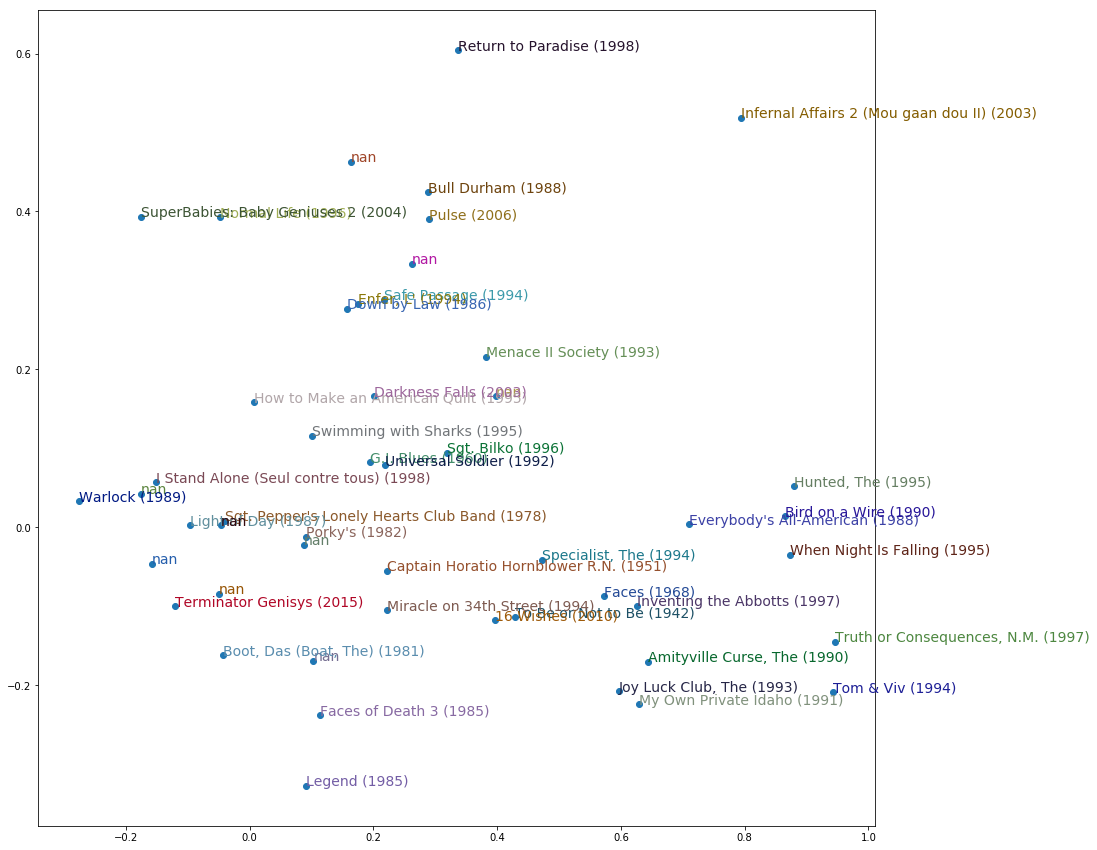

In [288]:
n = 50

sample = ratings.sample(n)

plt.figure(figsize=(15,15))
plt.scatter(sample.movie_pca0, sample.movie_pca1)

for i,s in sample.iterrows():
    plt.text(s.movie_pca0, s.movie_pca1, s.title, color=np.random.rand(3)*0.7, fontsize=14)

plt.show()